# Untitled Supermarked Project
Goal of the project is to gain insights on retail behaviour combining Data Science and Queuing Theory.

## Setting up Workshop

### Importing Libraries

In [1]:
# DataFrames
import pandas as pd
# Visualizations
import matplotlib.pyplot as plt
# Fancy Visualizations
import seaborn as sns
# Statistics
from scipy import stats 
# Array and Array Math
import numpy as np
# Time
import datetime as dt
# Anonymize Data
from faker import Faker
# Statistics
from scipy import stats 

### Importing own Functions
These functions are explained in the QSIM Jupyter Notebook.

In [2]:
import qsim as qs

### Settings

In [3]:
# Seed for Anonymizer
Faker.seed(0)
# Size of Graphs
plt.rcParams['figure.figsize'] = [10, 5]

## 01 : Import Data

Source: https://www.kaggle.com/agasca/retail-sales/data

In [4]:
data_raw = pd.read_csv(filepath_or_buffer = "Sales.csv")

## 02 : Clean Data
|Input|Tools & Techniques|Output|
|-|-|-|
|Raw Data|Rename Features|Clean Data|
||Handle Feature Format||
||Outliers||
||Anonymize Data||
||Select Features||

The dataset has no missing values.

In [5]:
data_cln = data_raw

### 02-01 : Rename Features
The Features will be translated for transparancy.

In [6]:
data_cln.columns = ['ID','time','price','paid','cashier']

### 02-02 : Handle Feature Format
Turning the 'time' feature into timestamp.

In [7]:
data_cln.time = pd.to_datetime(data_cln.time, format='%Y-%m-%d %H:%M:%S')

### 02-03 : Handle Outliers
Identify and mend outliers.

In [8]:
diff = (data_cln.paid / data_cln.price)

In [9]:
data_cln[stats.zscore(diff)>3]

,ID,time,price,paid,cashier
259,LBVT18020018893,2018-05-01 12:16:24,100.4,7.503003e+12,ALE HUERTA
13511,LBVT18010006703,2018-05-21 13:13:43,1039.7,7.501026e+12,JUAN MARTIN
37061,LBVT18030058152,2018-06-25 14:23:50,176.6,7.210597e+11,ALE HUERTA


<i>I am using the ratio of price to paid as an indicator. Here are the ones where the Zscore ist above 3, but there are many more where the "paid" value does not make sense. However, this issue is not crucial, and therefore be dealt with at a later point of time.</i>

### 02-04 : Anonymize Data
It is unknown if the Data has been allready anonymized, therefore the feature "cashier" might contain the actual names of the cashiers. To be on the safe side, new names will be generated.

In [10]:
fake = Faker('es_MX')
list_of_cashiers = data_cln.cashier.unique()
for idx_cshr in list_of_cashiers:
    data_cln.loc[(data_cln.cashier == idx_cshr),['cashier']] = fake.first_name().lower().replace(" ","")

<i> Technically, the feature also gives the information about the gender of the cashier, which could be utilized for analysis. This will be ignored for now and may be implemented at a later point in time.</i><br>

### 02-05 : Add Time between Transactions ('duration') as feature
Important for this analysis is the time it takes for a cashier to service a customer. As a first step I extract the time between the transactions, of each cashier and day seperatly. I do this since this information is often needed.

In [11]:
# Set up Collector for results
duration = pd.DataFrame(columns = ['ID','duration'])
# cycle through days
for idx_day in data_cln.time.dt.date.unique():
    # cycle through cashiers
    for idx_cash in data_cln[data_cln.time.dt.date == idx_day].cashier.unique():
        # Extract chosen days chosen cashiers transactions and sort by time
        temp = data_cln[(data_cln.time.dt.date == idx_day)&(data_cln.cashier == idx_cash)].sort_values("time")
        # Calculate and add the time passed between transactions
        temp['duration'] = np.append(np.nan,np.diff(temp.time).astype('timedelta64[s]').astype(int))
        # Add results to collector
        duration =  duration.append(temp[['ID','duration']])
# Join Data
data_cln = data_cln.join(duration.set_index('ID'), on = 'ID')
data_cln['duration'] = pd.to_timedelta(data_cln.duration, unit='s')

<i> This feature only shows the time between transaction, and not how long an transaction took. As it will be shown, it is highly likely that breaks are taken place in these times.</i>

### 02-06 : Select Features
The first one bears no usefull information for the analysis and will therefore be dropped.

In [12]:
data_cln = data_cln.drop('ID', axis = 1)

## 03 : Data Analysis
|Input|Tools & Techniques|Output|
|-|-|-|
|Clean Data|Single Feature Analysis|Insights|
||Multiple Feature Analysis|Assumptions|

### 03-01 : Single Feature Analysis

#### 03-01-01 : Time

In [13]:
print("Dataset spans from",
      data_cln.time.min(),
      "to",data_cln.time.max(),
      ". A timeperiod of",
      data_cln.time.max()-data_cln.time.min(),
      ".")

Dataset spans from 2018-05-01 07:46:22 to 2018-08-31 21:13:28 . A timeperiod of 122 days 13:27:06 .


C:\Users\hrmnn\Anaconda3\envs\HRMNN\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


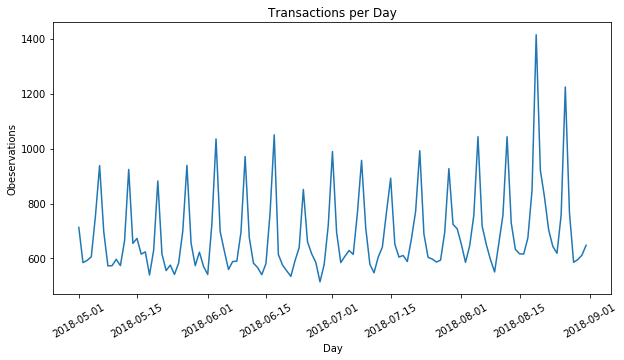

In [14]:
plt.title("Transactions per Day")
plt.plot(data_cln.resample("d", on = "time").count()["time"])
plt.ylabel("Obeservations")
plt.xlabel("Day")
plt.xticks(rotation = 30)
plt.show()

<b>Insights:</b><br>
- The market has between 500 and 1450 transactions every day.<br>
- There is a repeating pattern.<br>

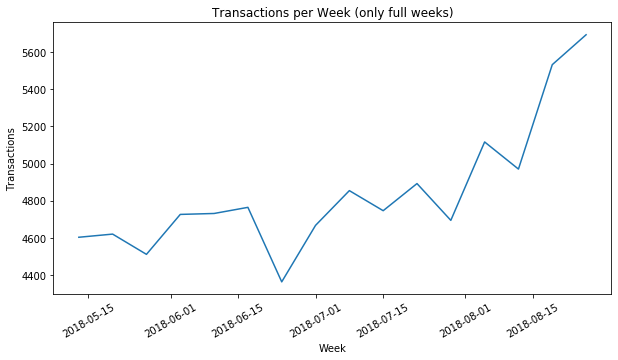

In [15]:
plt.title("Transactions per Week (only full weeks)")
plt.plot(data_cln.resample("W", on = "time").count()["time"][1:-1])
plt.ylabel("Transactions")
plt.xlabel("Week")
plt.xticks(rotation = 30)
plt.show()

<b>Insights:</b><br>
- The market has between 4350 and 5700 transactions every week.<br>
- It is stable around a 4600 transaction average for the first 10/11 weeks.
- But the number of transactions rises.<br>

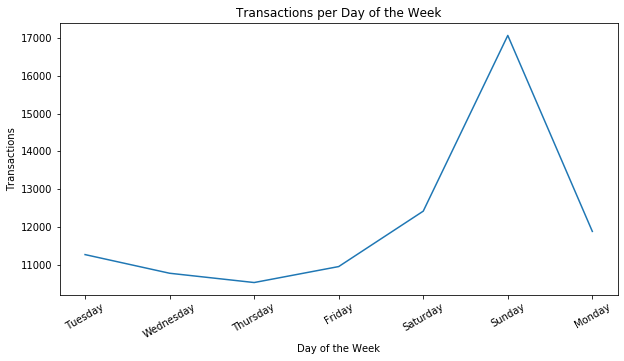

In [16]:
plt.title("Transactions per Day of the Week")
plt.plot(data_cln.groupby(data_cln.time.dt.day_name(), sort = False).time.count())
plt.ylabel("Transactions")
plt.xlabel("Day of the Week")
plt.xticks(rotation = 30)
plt.show()

<b>Insights:</b><br>
- All Workdays of the week have between 10000 and 12000 transactions.<br>
- All Saturdays saw a rough total of 12500, while the sum of Sunday transactions exceeds 17000.<br>
- The Minimum is in Thursday, the Maximum on Sunday.<br>
- The numbers rise and fall steadily from minimun and maximum and back<br>

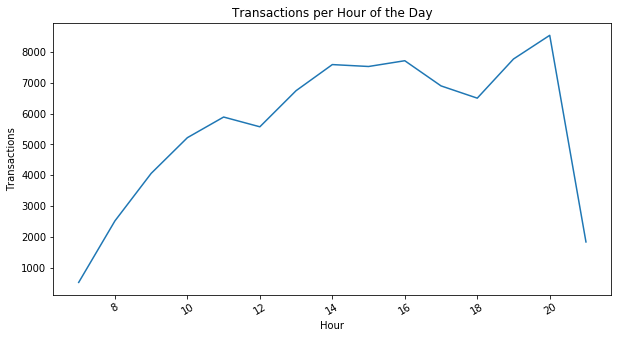

In [17]:
plt.title("Transactions per Hour of the Day")
plt.plot(data_cln.groupby(data_cln.time.dt.hour, sort = True).time.count())
plt.ylabel("Transactions")
plt.xlabel("Hour")
plt.xticks(rotation = 30)
plt.show()

<b>Insights:</b><br>
- No Transactions before 7.<br>
- No Transactions after 22.<br>
- Beginning in the morning the Transactions rise constantly to thier maximum at 20,<br>
- and then abruptly decline.<br>
- The mentioned rise has two significant dents: At 12/13 and 17/18.<br>

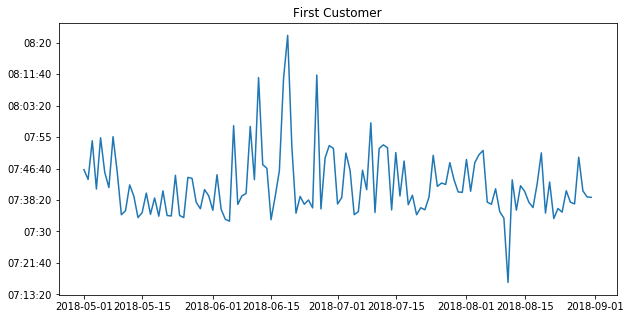

In [18]:
plt.title("First Customer")
plt.plot(data_cln.resample("D", on = "time").min()["time"].dt.time)
plt.ylabel("")
plt.show()

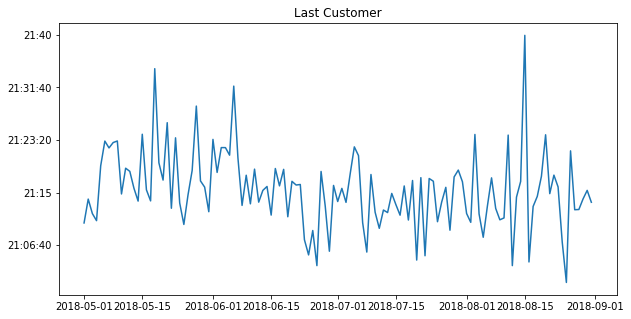

In [19]:
plt.title("Last Customer")
plt.plot(data_cln.resample("D", on = "time").max()["time"].dt.time)
plt.ylabel("")
plt.show()

<b>Assumptions:</b><br>
- The store opens at 07:30 and closes 21:30.<br>

#### 03-01-02 : Price

In [20]:
data_cln.price.describe()

count    84881.000000
mean       189.781109
std        284.032620
min      -1772.900000
25%         38.000000
50%         95.000000
75%        227.700000
max      13263.900000
Name: price, dtype: float64

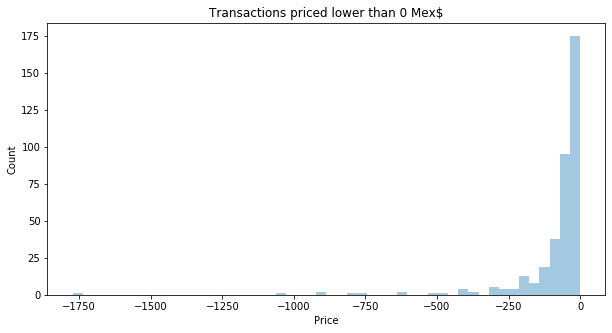

In [21]:
plt.title("Transactions priced lower than 0 Mex$")
sns.distplot(data_cln.price[data_cln.price <= 0] , kde = False)
plt.ylabel("Count")
plt.xlabel("Price")
plt.show()

<b>Insights:</b><br>
- There are transactions with a negative ammount of Mex$.<br>

<b>Assumptions:</b><br>
- These transactions represent instances where the price of the items bought is exceeded by the worth of items handed in (f.e. bottles for recycling). These observations are therefore not faulty values.<br>

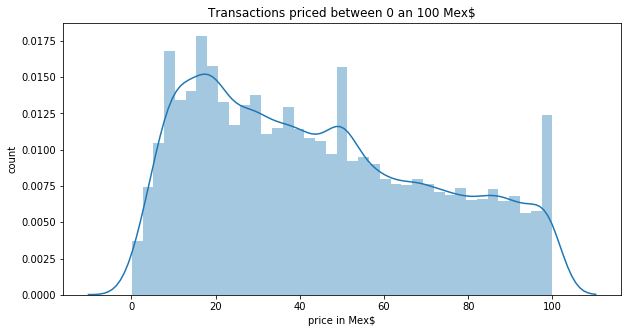

In [22]:
plt.title("Transactions priced between 0 an 100 Mex$")
sns.distplot(data_cln.price[(data_cln.price>=0)&(data_cln.price<=100)])
plt.ylabel("count")
plt.xlabel("price in Mex$")
plt.show()

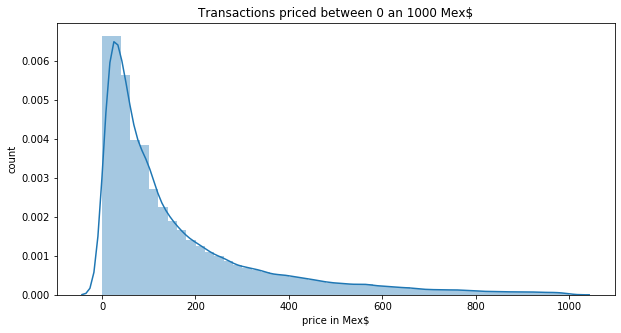

In [23]:
plt.title("Transactions priced between 0 an 1000 Mex$")
sns.distplot(data_cln.price[(data_cln.price>=0)&(data_cln.price<=1000)])
plt.ylabel("count")
plt.xlabel("price in Mex$")
plt.show()

<b>Insights:</b><br>
- The price seems to be normally distributed with the peak around 18 Mex$ and a heavy positive skew.<br>

#### 03-01-03 : Paid

<i>This Feature will be analyzed after the outlier issues have been solved</i>

#### 03-01-04 : Cashiers

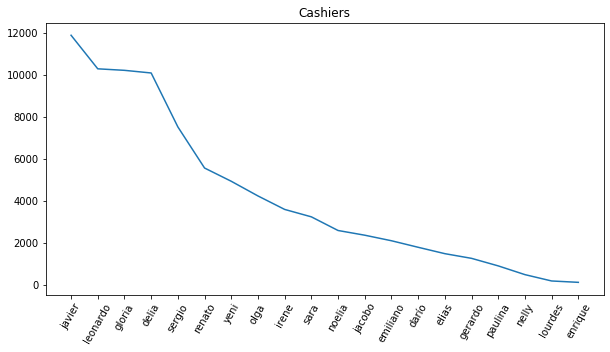

In [24]:
plt.title("Cashiers")
plt.plot(data_cln.cashier.value_counts())
plt.xticks(rotation = 60)
plt.show()

<b>Insights:</b><br>
- 21 Cashiers have been working in that supermarked in the timeperiod.<br>
- 4 of them have checked out more than 10k Transactions. The rest have all less than 7000 Transactions. <br>

#### 03-01-05 : Duration

In [25]:
data_cln.duration.describe()

count                     84006
mean     0 days 00:03:39.882948
std      0 days 00:08:21.178626
min             0 days 00:00:00
25%             0 days 00:00:46
50%             0 days 00:01:32
75%             0 days 00:03:16
max             0 days 07:35:32
Name: duration, dtype: object

<i> These numbers fuel the assumption that the time passed between customers is <b>not</b> the time it takes for the cashier to service a customer.</i>

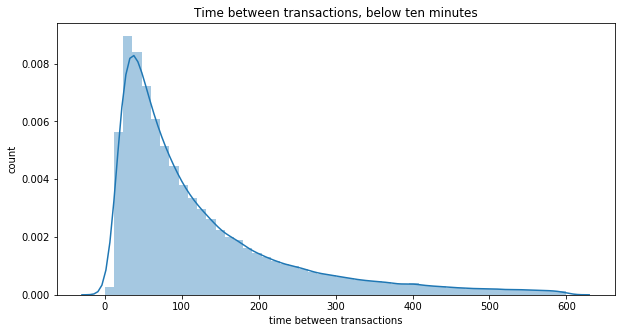

In [26]:
plt.title("Time between transactions, below ten minutes")
sns.distplot(data_cln.duration[data_cln.duration <= pd.to_timedelta(10*60, unit = 's')]/pd.Timedelta(seconds=1))
plt.ylabel("count")
plt.xlabel("time between transactions")
plt.show()

<i> This distribution heavily resembles the gamma-distribution, a distribution applied in queuing theory.</i>

### 03-02 : Multiple Feature Analysis

#### 03-02-01 : Correlations

<i> Postponed until Paid has been cleaned (outliers) </i>

#### 03-02-B : Time vs Paid

<i> Postponed until Paid has been cleaned (outliers) </i>

#### 03-02-C : Time vs Price

<i> Postponed because of low priority </i>

#### 03-02-D : Time vs Cashier

<i> Postponed because of low priority </i>

#### 03-02-E : Time vs Duration

<i> Postponed because of low priority </i>

#### 03-02-F : Paid vs Price

<i> Postponed until Paid has been cleaned (outliers) </i>

#### 03-02-G : Paid vs Cashier

<i> Postponed until Paid has been cleaned (outliers) </i>

#### 03-02-H : Paid vs Duration

<i> Postponed until Paid has been cleaned (outliers) </i>

#### 03-02-I : Price vs Cashier

<i> Postponed because of low priority </i>

#### 03-02-J : Price vs Duration

<i> Postponed because of low priority </i>

## 04 : Applying Queuing Theory

### 04-00 : Specific Functions

In [28]:
# Returns the Data for a given day
def grab_day(day):
    return data_cln[(data_cln.time>=day)&(data_cln.time<=day+dt.timedelta(days=1))]

In [29]:
# Visualizes the cashier and time of all transactions from a given day
def show_day(day):
    selected = grab_day(day)
    selected['time'] = selected.time.dt.time       
    plt.suptitle('Transactions by time and cashier')
    plt.title(str(day.date())+", a "+str(day.day_name()))
    sns.scatterplot(data = selected, y = "cashier", x = "time")
    plt.xticks(rotation=60)
    plt.show()

In [154]:
# Takes the Transactions from a chosen date and extracts each cashiers shift
def shiftplan(day):
    selected            = grab_day(day)
    shift_plan          = pd.DataFrame([])
    shift_start         = selected.groupby("cashier").min()["time"]
    shift_end           = selected.groupby("cashier").max()["time"]
    shift_plan["start"] = shift_start
    shift_plan          = shift_plan.merge(shift_end, on = "cashier", how = "inner")
    shift_plan.rename(columns={"time": "end"}, inplace = True)
    return shift_plan.reset_index()

In [159]:
# Takes the shifts and visualizes them
def show_shifts(shiftplan):
    plt.xlim(shiftplan.start.min(),shiftplan.end.max())
    for idx in range(0,shiftplan.shape[0]):

        plt.broken_barh([(shiftplan.start[idx], shiftplan.end[idx] - shiftplan.start[idx])], (idx-0.25, 0.5))
        plt.yticks(range(0,shiftplan.shape[0]),(list(shiftplan.cashier)))
    plt.show() 

### 04-01 : Turning Data into Parameters for Queues

The basic parameters for queuing theory are: The Entry Process, the Service Process and the number of Service Stations.<br>
<b>The Entry Process:</b> A random process determining when the next customer is arriving.<br>
<b>The Service Process:</b> A random process determining how long a customer is processed by a station.<br>
<b>Number of Stations:</b> Number of active stations that are processing customers.<br>
These parameters are explained in the QSIM Jupyter Notebook in more detail.<br><br>

This chapter will demonstrate the different ways these parameters can be extracted from the dataset.

#### 04-01-01 : Number of Service-Stations

The information given in the dataset can be utilized to determine how many registers were open at any time.

C:\Users\hrmnn\Anaconda3\envs\HRMNN\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


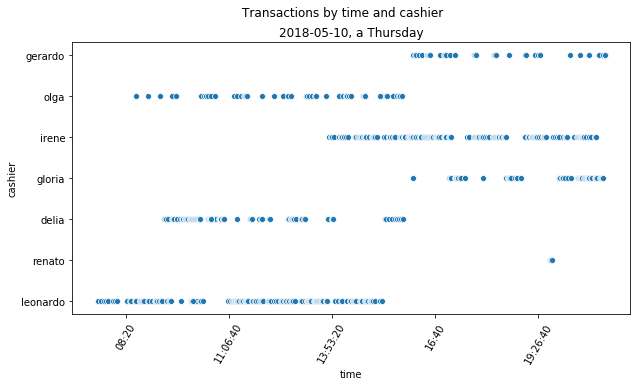

In [35]:
show_day(pd.Timestamp(dt.date(2018,5,10)))

However, as noted in 03-01-05, it is unlikely that the register was manned by a cashier in all the gaps between the transactions. The goal is to get closer to the truth by making smart assumptions.

##### 04-01-01-A : Shift = Cashier
The employee sits at the register from his first transaction, until his/ her last. No breaks.

In [161]:
shifts = shiftplan(day)
shifts

,cashier,start,end
0,delia,2018-05-10 09:22:24,2018-05-10 15:48:52
1,gerardo,2018-05-10 16:04:13,2018-05-10 21:14:47
2,gloria,2018-05-10 16:03:47,2018-05-10 21:11:39
3,irene,2018-05-10 13:49:17,2018-05-10 21:00:22
4,leonardo,2018-05-10 07:34:26,2018-05-10 15:14:36
5,olga,2018-05-10 08:36:52,2018-05-10 15:46:37
6,renato,2018-05-10 19:45:34,2018-05-10 19:48:57


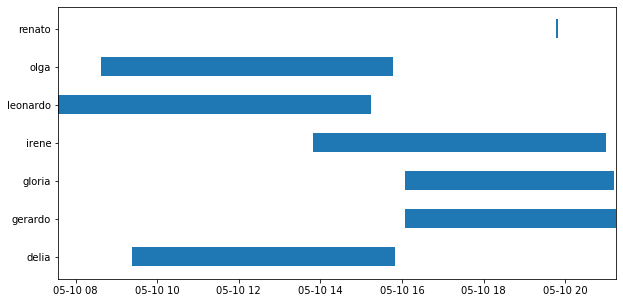

In [162]:
show_shifts(shifts)

In [222]:
taser = []
temp_starts = (shifts.start - shifts.start.min()).dt.total_seconds()
temp_ends   = (shifts.end - shifts.start.min()).dt.total_seconds()


for idx in range(0, shifts.shape[0]):
    temp_temp_ends = temp_ends[idx]
    if temp_ends[idx] == temp_ends.max():
        temp_temp_ends = np.nan
        
    taser.append((temp_starts[idx], temp_temp_ends))

##### 04-01-02-B : Identifying Breaks

In [ ]:
The 

#### 04-01-02 : Service Process

##### 04-01-02-A : Stationary
https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.gamma.html#scipy.stats.gamma

In [ ]:
# A) Recieve Shift
# ) Get Differences
# B) Determine Distribution (EXP)
# C) Determine Lambda

##### 04-01-02-B : non-Stationary

<i>This will be considered once this feature has been implemented in QSIM.</i>

#### 04-01-03 : Entry Process

##### 04-01-03-01 : Stationary
The random variable, determining the time between each customer entering the queuing-system, does not change intra-day ("stationary") .<br>

###### 04-01-03-01-A : Stationary and Universal
In addition to beeing independent from the daytime, this process is also not dependent from other factors, like cashier or weekday ("universality").

#### 04-01-03-B : non-Stationary

<i>This will be considered once this feature has been implemented in QSIM.</i>

## 04-02 : Putting it Together

### 04-02-A : Scenario A
<b>Entry Process:</b> Stationary and Universal<br>
<b>Service Process:</b> Stationary and Universal<br>
<b>Number of Service Stations:</b> Employee is at register from first to last transactions, no breaks (<b>A</b>lpha)<br>

In [163]:
entry_rate   = grab_day(pd.Timestamp(dt.date(2018,5,10))).count()[0] / (grab_day(pd.Timestamp(dt.date(2018,5,10))).time.max() - grab_day(pd.Timestamp(dt.date(2018,5,10))).time.min()).total_seconds()
service_rate = 1 / grab_day(pd.Timestamp(dt.date(2018,5,10))).duration.mean().total_seconds()

In [164]:
pick = grab_day(pd.Timestamp(dt.date(2018,5,10))).sort_values('time').reset_index(drop = True).time

In [165]:
pick = pick - pick.min()

In [166]:
pick = pick.dt.total_seconds().astype(int)

In [167]:
pcik = pd.DataFrame([])
pcik["exit"] = pick

In [239]:
test = qs.alotta_queues (runs                 = 1000,
                  n_customers                 = grab_day(pd.Timestamp(dt.date(2018,5,10))).count()[0],
                  entry_variable              = stats.expon.rvs,
                  entry_variable_parameters   = {"loc" : 0, "scale" : 1/entry_rate},
                  service_variable            = stats.expon.rvs,
                  service_variable_parameters = {"loc" : 0, "scale" : 1/service_rate},
                  shifts                      = taser)
                  #shifts                      = [(0,np.nan),(0,np.nan),(0,np.nan)])

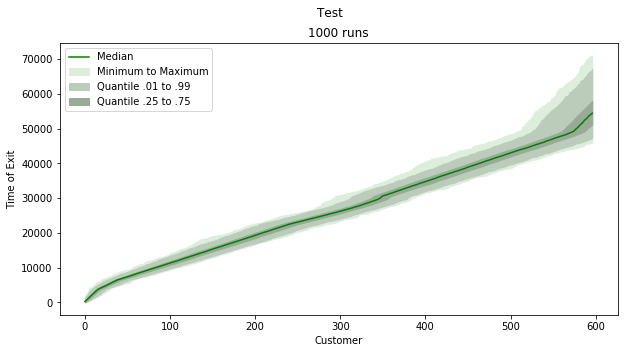

In [240]:
qs.show_mcq(test, "Test", True)

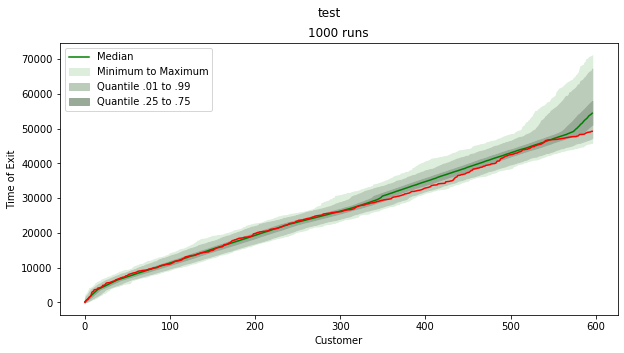

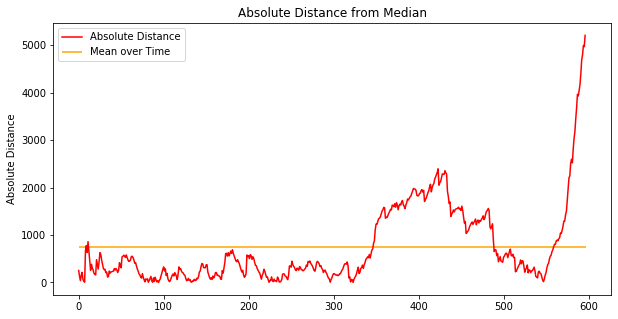

737.7508120567431

In [241]:
title = "test"
qs.compare(test, pcik, True, "test")

## Work in Progress

In [ ]:
def check_time(start, end, suspect):
    return((suspect >= start) & (suspect <= end))

In [ ]:
def check_shiftplan(shiftplan, suspect):
    result = 0
    for idx in shiftplan.index:
        result += check_time(shiftplan.start[idx], shiftplan.end[idx], suspect)                    
    return result

In [ ]:
def find_active_shifts(day):
    shiftplan = show_shiftplan(day)
    results = []
    for idx in grab_day(day).time:
        results.append(check_shiftplan(shiftplan, idx))
    return results

In [ ]:
def show_active_shifts(day):
    data         = grab_day(day)
    data["open"] = find_active_shifts(day)
    data         = data.sort_values("time")
    data         = data.reset_index()
    
    plt.title("Active Shifts, includes Breaketime")
    plt.scatter(y = data.open, x = data.time)
    plt.yticks(range(0,data.open.max()+1))
    plt.xlim(data.time.min(),data.time.max())
    plt.show()

In [ ]:
# 04-01
# Visualize Exit-Process
test = pd.DataFrame(grab_day(pd.Timestamp(dt.date(2018,5,10))).sort_values("time").time).reset_index(drop = True)
test["customer"] = pd.DataFrame(np.cumsum(np.repeat(1,len(test_time)))).reset_index(drop = True)
sns.scatterplot(data = test, x = "time", y = "customer")
plt.xlim([test.time.min(),test.time.max()])
plt.title("Transactions over time / Exit Process")
plt.show()

In [ ]:
# 04-01-02:
# Determine and Visualize Time between Transactions
lam = grab_day(pd.Timestamp(dt.date(2018,5,10)))
result = pd.DataFrame([])
for idx_csr in lam.cashier.unique():
    shift   = pd.DataFrame(lam[lam.cashier == idx_csr].sort_values("time").reset_index(drop=True)).time
    shift   = pd.DataFrame(np.diff(shift))
    result  = result.append(shift, ignore_index = True)
results = result.sort_values(0).reset_index(drop = True)
results = results[0].astype('timedelta64[s]')
plt.hist(results[results<=100], bins = 100)
plt.show()
plt.hist(results[results<=1000], bins = 100)
plt.show()
plt.hist(results, bins = 100)
plt.show()

In [ ]:
https://www.kaggle.com/agasca/analyze-data
https://www.kaggle.com/ector777/cashier-performance-analysis    

In [ ]:
results

In [ ]:
expon.fit(data = results)

In [ ]:
Category 
pd.DataFrame(data['cashier']).astype('category')

In [ ]:
resultz = pd.DataFrame(columns = ['time','cashier','difference'])
# cycle through days
for idx_day in data_cln.time.dt.date.unique():
    # cycle through cashiers
    for idx_cash in data_cln[data_cln.time.dt.date == idx_day].cashier.unique():
        temp_resultz = pd.DataFrame(columns = ['time','cashier','difference'])    
        temp_resultz['time']       = data_cln[(data_cln.time.dt.date == idx_day)&(data_cln.cashier == idx_cash)].sort_values("time").reset_index(drop = True).time
        temp_resultz['cashier']    = data_cln[(data_cln.time.dt.date == idx_day)&(data_cln.cashier == idx_cash)].sort_values("time").reset_index(drop = True).cashier
        temp_resultz['difference'] = np.append(np.nan,np.diff(temp_resultz.time).astype('timedelta64[s]').astype(int))    
        resultz =  resultz.append(temp_resultz)
        
        
plt.title("Time Between Transactions")
newx = resultz.difference.sort_values().reset_index( drop = True)/60
newy = np.linspace(0, 1, resultz.shape[0])
plt.scatter(y = newy, x = newx)
plt.xlabel("Minutes")
plt.show()

## Future Works

<b>Overall Project</b><br>
- Create Annex: Vocabulary<br>
- Create Annex: Insights<br>
- Create Annex: Assumptions
- Come up with Supermarket related pun as project title<br>
- Put extensive analysis into seperate Jupyter Notebook, only put necessary results here<br>
- Peer Review<br>
- Additional Opportunities for Machine Learning<br>
- Finish readme<br>
- Make Presentation<br>

<b>Code</b><br>
- Fix 03-01-01 Warning<br>
- Polish Code<br>
- Comment Code<br>

<b>Cleaning</b><br>
- Handle Outliers (Ideas: price, regression model, based on Mex$ coins/ bills)<br>

<b>Analysis</b><br>
- <b>!QT Charts need better legends/ phrasing!</b><br>
- Analyse according to Priorization<br>
- Labor Day and all days used?<br>
- Systematically splitter Time<br>
- Add Histograms to 03-01-01 = Analyse Frequency<br>
- Create Multiplot for 03-01-02<br>
- Confirm Assumption on Opening Hours for all weekdays<br>
- Estimate Shopping Time via OH vs First Transaction
- "Observations per Week (only full weeks)" apply .isocalendar()[1]<br>
- Analysis of Gender<br>
- Effects of Daylight Savingstime<br>
- Consider Interactive visualization (bokeh)<br>

<b>Apply Queing Theory</b><br>
- Service-Station: Vacant vs (Idle vs Working): No Diffrence -> Assoumption based on time -> Deduce from Supermarket Busyness (of other Stations + Total)
- Service Station: End of the Day Issue (How many open registers at the end of the day in the QSIM?)<br>
- Service Process (Stationary vs Nonstationary, Independent vs Dependent(Price, Cashier, Paid, Weekday, Month, etc.))
- Entry Process(Stationary vs Nonstationary, Indpendent vs Dependent(Price, Cashier, Paid, Weekday, Month, etc.)
- Entry Process (Shopping Time)
- Evaluation of Settings (= Compare Exit Processes)<br>
- Queing Networks (= Multiple queues)<br>
- y Ticks Format Dayview<br>